# Lattice Neighbor Packing: How Dense is the Crystal?

Each vector in 2560D has **5,120 immediate lattice neighbors** (±1 ULP in each dimension).

For a random sparse cloud, we'd expect ~0% of these neighbors to be occupied.

For a crystal, we might see significant neighbor occupation - vectors touching each other at the quantum scale.

This notebook:
- For each core vector, count how many of its 5,120 potential neighbors exist in the core
- Compute packing fraction = (occupied neighbors) / 5,120
- Show distribution of packing fractions
- Identify vectors with highest packing (the crystal nuclei)

Even 0.5% packing would be remarkable in 2560D - it means ~25 neighbors touching you.

## Parameters

In [1]:
# Paths
CORE_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.11i_core_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Visualization
DPI = 200
SHOW_TOP_N_PACKED = 10  # Show N most densely packed vectors

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from tqdm import tqdm

## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [4]:
# Load core cluster token IDs
core_data = load_file(CORE_TOKENS_PATH)
core_token_ids = core_data['cluster_token_ids'].to(device)

print(f'Loaded {len(core_token_ids)} core token IDs')

Loaded 2206 core token IDs


In [5]:
# Load gamma matrix in bfloat16
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.bfloat16).to(device)

print(f'Loaded gamma matrix: {W.shape}')
print(f'Precision: {W.dtype}')

Loaded gamma matrix: torch.Size([151936, 2560])
Precision: torch.bfloat16


In [6]:
# Extract core vectors
core_vectors = W[core_token_ids]

print(f'Extracted {core_vectors.shape[0]} vectors of dimension {core_vectors.shape[1]}')

Extracted 2206 vectors of dimension 2560


## Find Unique Vectors

In [7]:
# Find unique vectors (stay in bfloat16)
unique_vectors, inverse_indices = torch.unique(core_vectors.to('cpu'), dim=0, return_inverse=True)
unique_vectors = unique_vectors.to(device)
inverse_indices = inverse_indices.to(device)

populations = torch.bincount(inverse_indices)

print(f'Found {len(unique_vectors)} unique vectors')
print(f'Precision: {unique_vectors.dtype}')
print(f'Population range: {populations.min().item()} to {populations.max().item()}')
print()
print(f'Each vector has 2 × {unique_vectors.shape[1]} = {2 * unique_vectors.shape[1]} potential lattice neighbors')
print(f'  (±1 ULP in each dimension)')

Found 122 unique vectors
Precision: torch.bfloat16
Population range: 1 to 814

Each vector has 2 × 2560 = 5120 potential lattice neighbors
  (±1 ULP in each dimension)


## Helper: Next/Previous bfloat16 Value

In [8]:
def nextafter_bfloat16(x_bf16, direction):
    """
    Get the next bfloat16 value after x in the given direction.

    Args:
        x_bf16: bfloat16 tensor (scalar)
        direction: +1 for next toward +inf, -1 for next toward -inf

    Returns:
        Next bfloat16 value
    """
    # Work with float32 representation (bfloat16 is upper 16 bits of float32)
    x_f32 = x_bf16.to(torch.float32)

    # Convert to uint32 bit pattern
    x_bits = x_f32.view(torch.int32).item()

    # Handle special cases
    if x_bits == 0:  # Zero
        if direction > 0:
            return torch.tensor(2**(-133), dtype=torch.bfloat16)  # Smallest positive subnormal
        else:
            return torch.tensor(-2**(-133), dtype=torch.bfloat16)  # Smallest negative subnormal

    # For bfloat16: increment/decrement by 2^16 in float32 bit pattern
    # (because bfloat16 uses upper 16 bits of float32)
    if direction > 0:
        if x_bits > 0:
            x_bits += (1 << 16)  # Add 1 to bfloat16 mantissa
        else:
            x_bits -= (1 << 16)  # Subtract 1 from bfloat16 mantissa (moves toward zero)
    else:
        if x_bits > 0:
            x_bits -= (1 << 16)  # Subtract 1 from bfloat16 mantissa (moves toward zero)
        else:
            x_bits += (1 << 16)  # Add 1 to bfloat16 mantissa (more negative)

    # Convert back to float32, then to bfloat16
    x_next_f32 = torch.tensor(x_bits, dtype=torch.int32).view(torch.float32)
    x_next_bf16 = x_next_f32.to(torch.bfloat16)

    return x_next_bf16

# Test
test_val = torch.tensor(0.5, dtype=torch.bfloat16)
test_next = nextafter_bfloat16(test_val, +1)
test_prev = nextafter_bfloat16(test_val, -1)

print(f'Test: 0.5 (bfloat16)')
print(f'  Next: {test_next.item():.10f}')
print(f'  Prev: {test_prev.item():.10f}')
print(f'  Gap: {(test_next - test_prev).item():.6e}')
print(f'  Expected ULP at 0.5: {2**(int(np.floor(np.log2(0.5))) - 7):.6e}')

Test: 0.5 (bfloat16)
  Next: 0.5039062500
  Prev: 0.4980468750
  Gap: 5.859375e-03
  Expected ULP at 0.5: 3.906250e-03


## Build Fast Lookup: Vector Set

In [9]:
# Convert unique vectors to hashable tuples using bit patterns
# This avoids float32 precision issues

print('Building vector lookup set...')

unique_vectors_cpu = unique_vectors.cpu()

def vec_to_hashable(vec_bf16):
    """Convert bfloat16 vector to hashable tuple using bit patterns."""
    # View as int16 bit patterns (each bfloat16 value → 16 bits)
    # This gives exact equality without float precision issues
    return tuple(vec_bf16.view(torch.int16).numpy())

# Create set of vector tuples for fast lookup
vector_set = set()
for i in range(len(unique_vectors_cpu)):
    vec_tuple = vec_to_hashable(unique_vectors_cpu[i])
    vector_set.add(vec_tuple)

print(f'✓ Created lookup set with {len(vector_set)} unique vectors')
print(f'  (Each vector hashed as tuple of {len(unique_vectors_cpu[0])} int16 bit patterns)')

Building vector lookup set...
✓ Created lookup set with 122 unique vectors
  (Each vector hashed as tuple of 2560 int16 bit patterns)


## Count Lattice Neighbors for Each Vector

In [10]:
print('Counting unique lattice neighbors for each vector...')
print('This may take a few minutes for 2560 dimensions × 122 vectors...')
print()

num_dims = unique_vectors.shape[1]
max_possible_neighbors = 2 * num_dims  # ± in each dimension

neighbor_counts = []

for vec_idx in tqdm(range(len(unique_vectors_cpu)), desc='Checking neighbors'):
    vec = unique_vectors_cpu[vec_idx].clone()
    
    # Use a SET to collect unique neighbors
    unique_neighbors = set()
    
    # Check each dimension
    for dim_idx in range(num_dims):
        original_val = vec[dim_idx]
        
        # Try +1 ULP
        vec[dim_idx] = nextafter_bfloat16(original_val, +1)
        vec_tuple = vec_to_hashable(vec)
        if vec_tuple in vector_set and vec_tuple != vec_to_hashable(unique_vectors_cpu[vec_idx]):
            unique_neighbors.add(vec_tuple)
          
        # Try -1 ULP
        vec[dim_idx] = nextafter_bfloat16(original_val, -1)
        vec_tuple = vec_to_hashable(vec)
        if vec_tuple in vector_set and vec_tuple != vec_to_hashable(unique_vectors_cpu[vec_idx]):
            unique_neighbors.add(vec_tuple)
        
        # Restore original
        vec[dim_idx] = original_val
    
    neighbor_counts.append(len(unique_neighbors))

neighbor_counts = np.array(neighbor_counts)

print(f'\n✓ Neighbor counting complete')
print(f'  Vectors analyzed: {len(neighbor_counts)}')
print(f'  Counting UNIQUE neighbors (not dimension-wise hits)')
print(f'  Max possible unique neighbors: up to {max_possible_neighbors} (theoretical)')

Counting unique lattice neighbors for each vector...
This may take a few minutes for 2560 dimensions × 122 vectors...



Checking neighbors: 100%|██████████| 122/122 [00:53<00:00,  2.29it/s]


✓ Neighbor counting complete
  Vectors analyzed: 122
  Counting UNIQUE neighbors (not dimension-wise hits)
  Max possible unique neighbors: up to 5120 (theoretical)


## Compute Packing Fractions

In [11]:
# Packing fraction = (occupied neighbors) / (max possible neighbors)
packing_fractions = neighbor_counts / max_possible_neighbors
packing_percentages = 100 * packing_fractions

print('='*70)
print('LATTICE NEIGHBOR PACKING ANALYSIS')
print('='*70)
print(f'\nGlobal statistics:')
print(f'  Total unique vectors: {len(unique_vectors)}')
print(f'  Max possible neighbors per vector: {max_possible_neighbors:,}')
print()
print(f'Neighbor counts:')
print(f'  Minimum: {neighbor_counts.min()}')
print(f'  Maximum: {neighbor_counts.max()}')
print(f'  Mean: {neighbor_counts.mean():.2f}')
print(f'  Median: {np.median(neighbor_counts):.0f}')
print()
print(f'Packing fractions:')
print(f'  Minimum: {packing_fractions.min():.6f} ({packing_percentages.min():.4f}%)')
print(f'  Maximum: {packing_fractions.max():.6f} ({packing_percentages.max():.4f}%)')
print(f'  Mean: {packing_fractions.mean():.6f} ({packing_percentages.mean():.4f}%)')
print(f'  Median: {np.median(packing_fractions):.6f} ({np.median(packing_percentages):.4f}%)')
print()

# Count vectors with at least one neighbor
n_with_neighbors = np.sum(neighbor_counts > 0)
print(f'Vectors with at least 1 neighbor: {n_with_neighbors} / {len(neighbor_counts)} '
      f'({100*n_with_neighbors/len(neighbor_counts):.1f}%)')

print('='*70)

LATTICE NEIGHBOR PACKING ANALYSIS

Global statistics:
  Total unique vectors: 122
  Max possible neighbors per vector: 5,120

Neighbor counts:
  Minimum: 0
  Maximum: 3
  Mean: 0.20
  Median: 0

Packing fractions:
  Minimum: 0.000000 (0.0000%)
  Maximum: 0.000586 (0.0586%)
  Mean: 0.000038 (0.0038%)
  Median: 0.000000 (0.0000%)

Vectors with at least 1 neighbor: 15 / 122 (12.3%)


## Top Packed Vectors

In [12]:
# Sort by neighbor count (descending)
sorted_indices = np.argsort(neighbor_counts)[::-1]

print(f'\nTop {SHOW_TOP_N_PACKED} most densely packed vectors:')
print('='*70)
print(f'  {"Rank":>4} {"Neighbors":>10} {"Fraction":>10} {"Percentage":>12} {"Population":>10}')
print(f'  {"-" * 4} {"-" * 10} {"-" * 10} {"-" * 12} {"-" * 10}')

for rank, idx in enumerate(sorted_indices[:SHOW_TOP_N_PACKED], 1):
    n_neighbors = neighbor_counts[idx]
    frac = packing_fractions[idx]
    pct = packing_percentages[idx]
    pop = populations[idx].item()
    
    print(f'  {rank:4d} {n_neighbors:10d} {frac:10.6f} {pct:11.4f}% {pop:10d}')


Top 10 most densely packed vectors:
  Rank  Neighbors   Fraction   Percentage Population
  ---- ---------- ---------- ------------ ----------
     1          3   0.000586      0.0586%        704
     2          2   0.000391      0.0391%          1
     3          2   0.000391      0.0391%          1
     4          2   0.000391      0.0391%        814
     5          2   0.000391      0.0391%        228
     6          2   0.000391      0.0391%          4
     7          2   0.000391      0.0391%          1
     8          2   0.000391      0.0391%        306
     9          1   0.000195      0.0195%          1
    10          1   0.000195      0.0195%          1


## Histogram: Neighbor Count Distribution

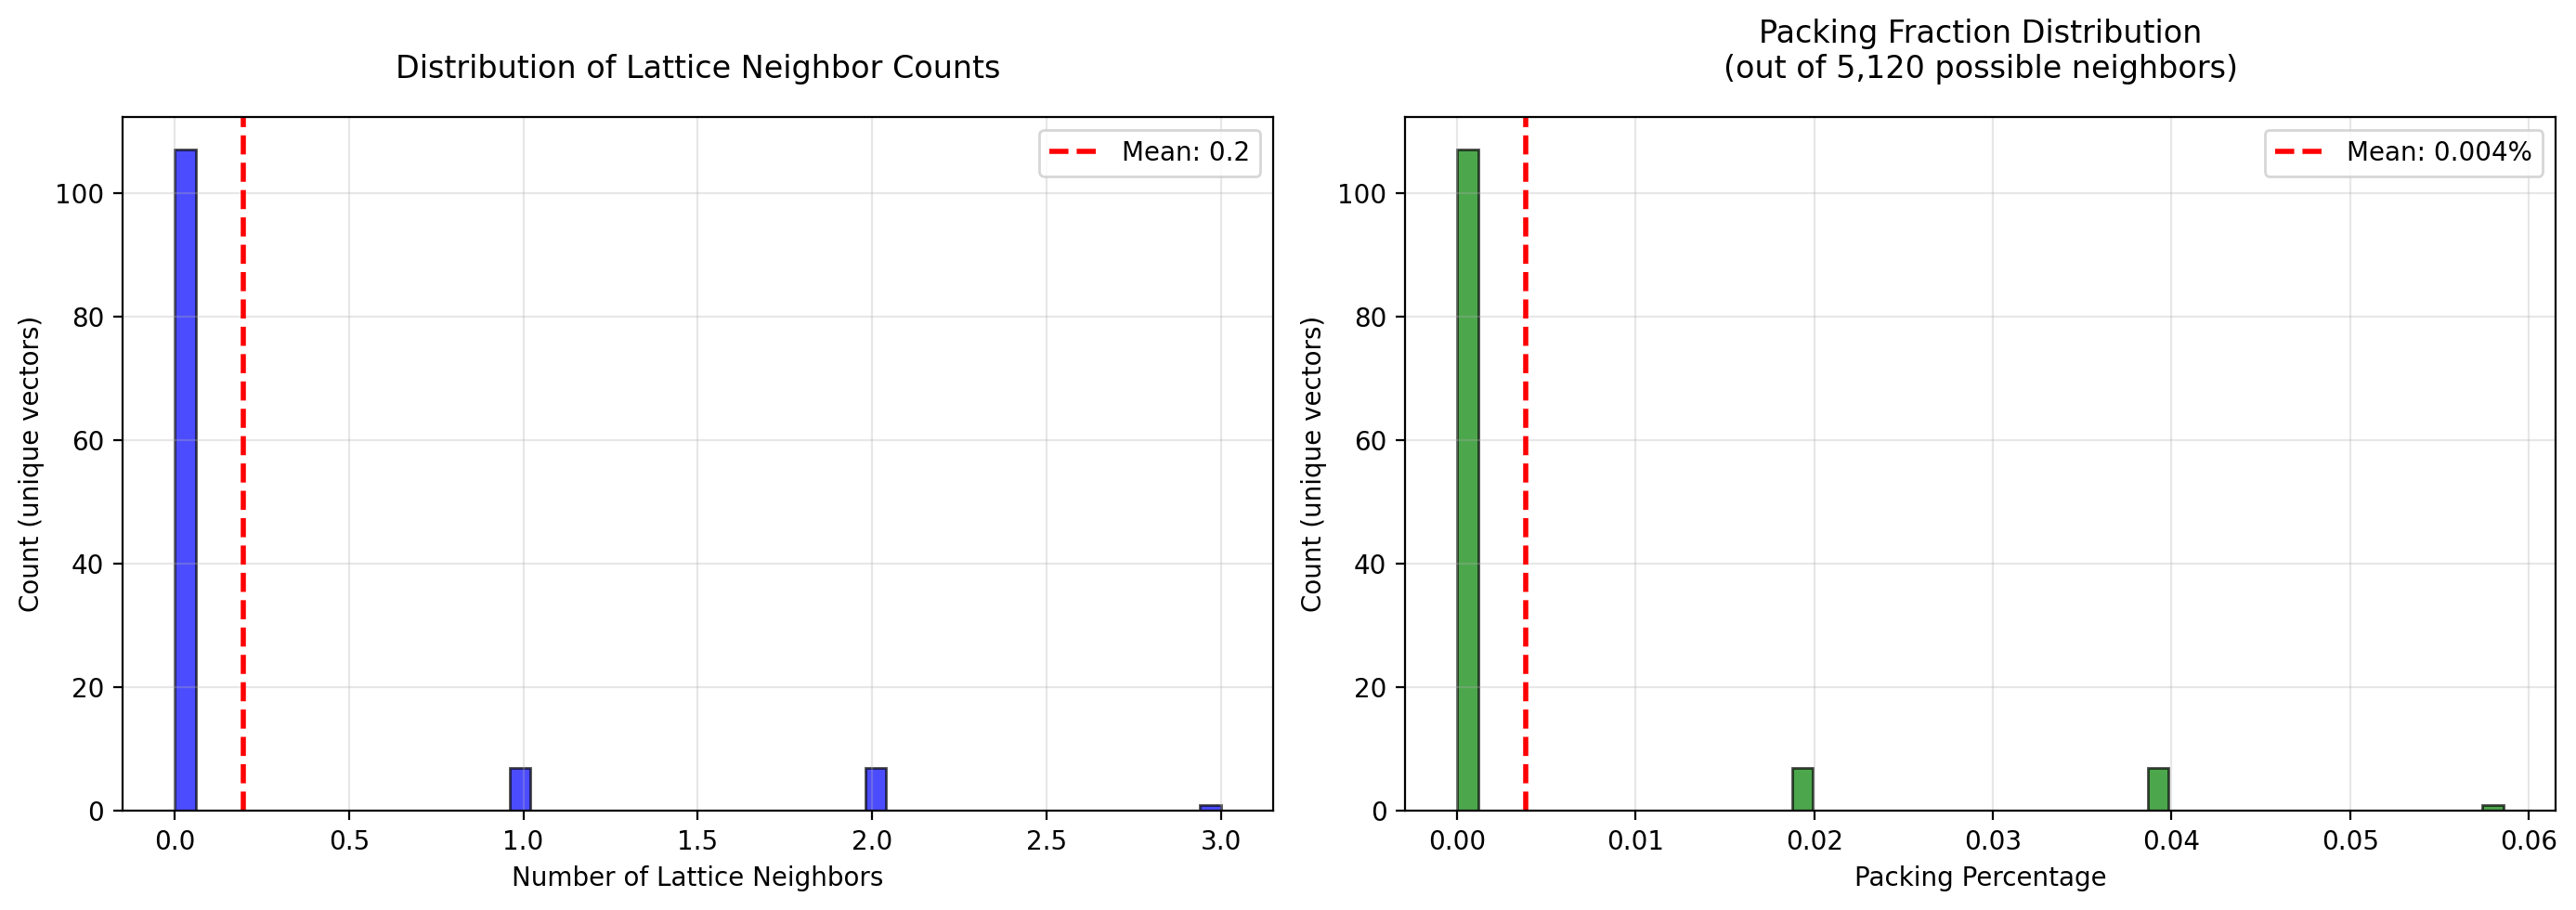

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Neighbor counts
ax1.hist(neighbor_counts, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax1.axvline(neighbor_counts.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {neighbor_counts.mean():.1f}')
ax1.set_xlabel('Number of Lattice Neighbors', color='black')
ax1.set_ylabel('Count (unique vectors)', color='black')
ax1.set_title('Distribution of Lattice Neighbor Counts', color='black', pad=15)
ax1.tick_params(colors='black')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Packing percentages
ax2.hist(packing_percentages, bins=50, color='green', alpha=0.7, edgecolor='black')
ax2.axvline(packing_percentages.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {packing_percentages.mean():.3f}%')
ax2.set_xlabel('Packing Percentage', color='black')
ax2.set_ylabel('Count (unique vectors)', color='black')
ax2.set_title(f'Packing Fraction Distribution\n(out of {max_possible_neighbors:,} possible neighbors)',
              color='black', pad=15)
ax2.tick_params(colors='black')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Packing vs Population

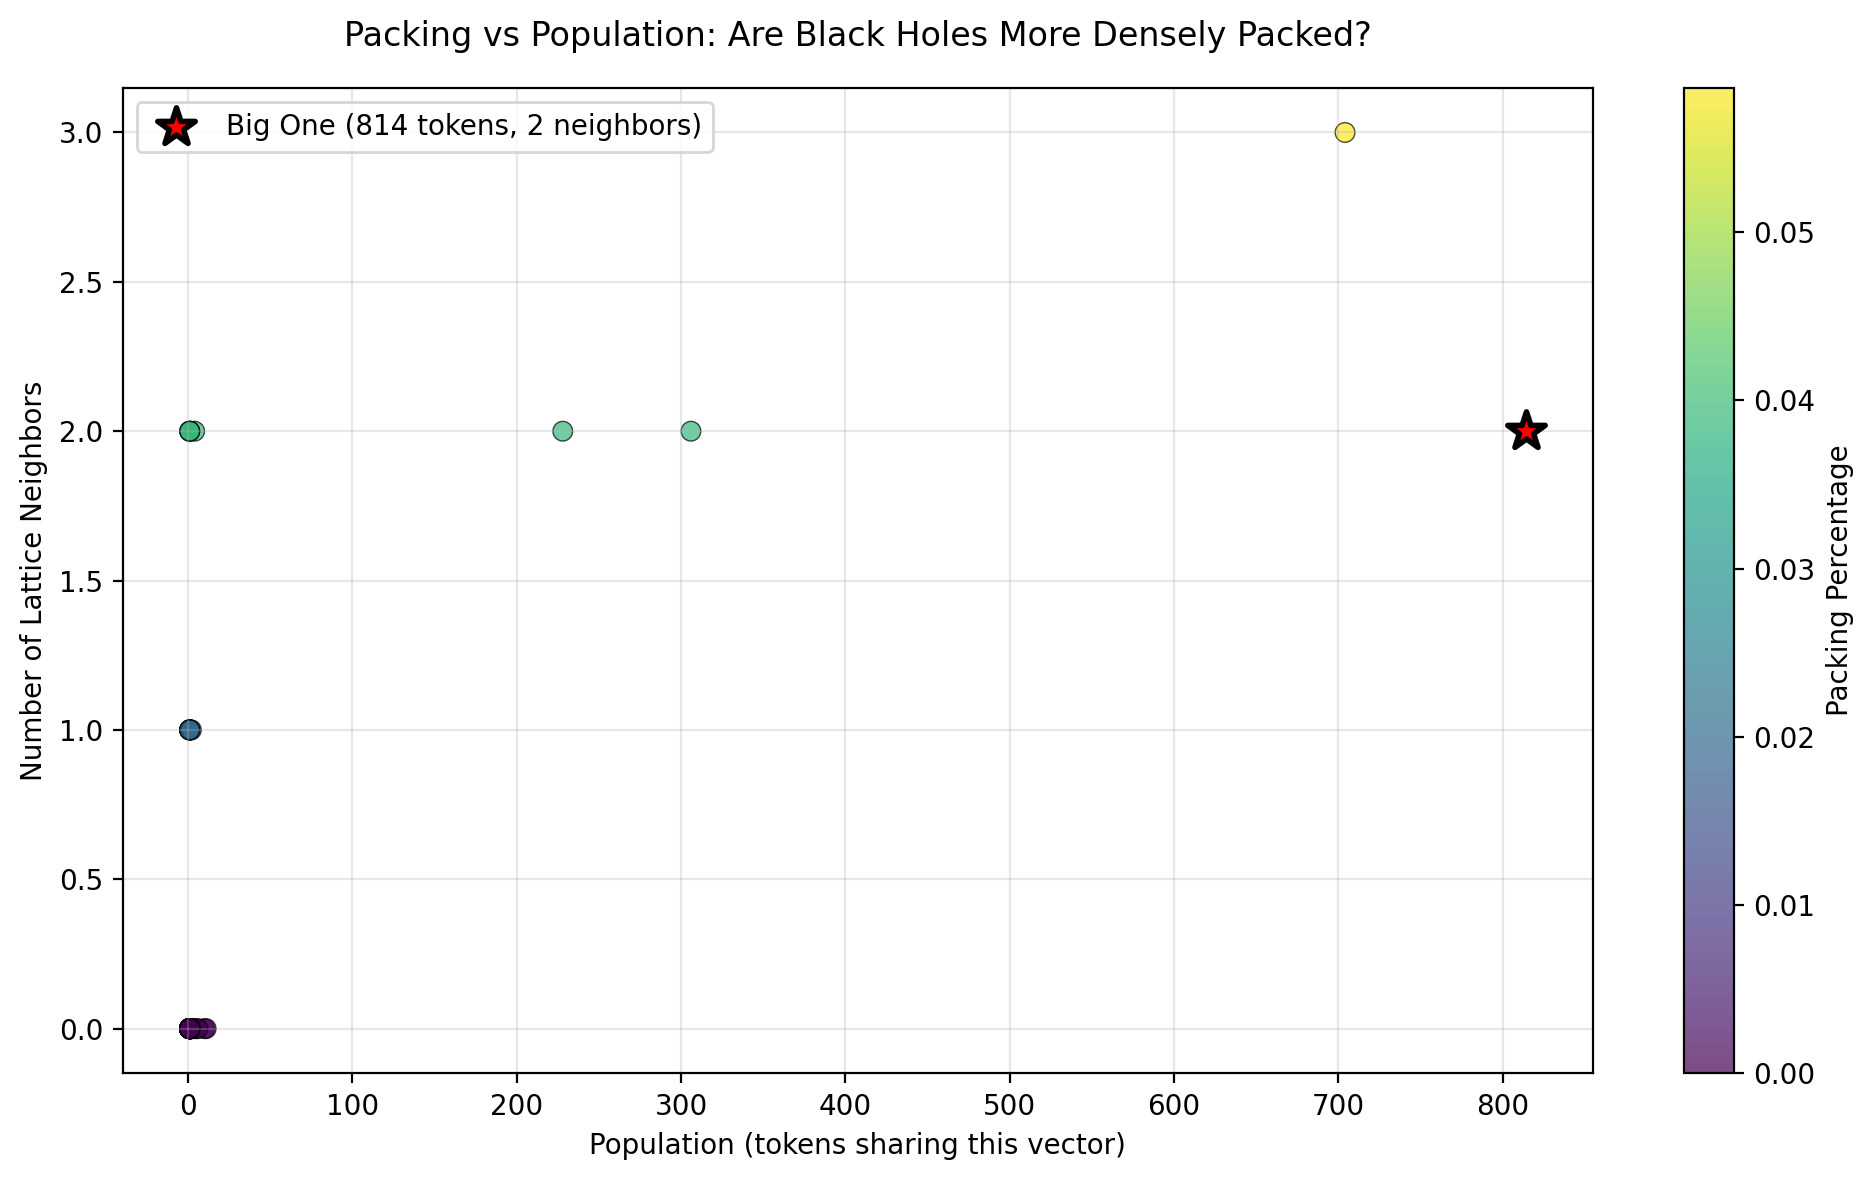

In [14]:
# Does the Big One have more neighbors?
populations_np = populations.cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

scatter = ax.scatter(populations_np, neighbor_counts, c=packing_percentages, 
                     cmap='viridis', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Packing Percentage', color='black')

ax.set_xlabel('Population (tokens sharing this vector)', color='black')
ax.set_ylabel('Number of Lattice Neighbors', color='black')
ax.set_title('Packing vs Population: Are Black Holes More Densely Packed?', color='black', pad=15)
ax.tick_params(colors='black')
ax.grid(True, alpha=0.3)

# Highlight the Big One
big_one_idx = populations_np.argmax()
ax.scatter([populations_np[big_one_idx]], [neighbor_counts[big_one_idx]], 
           s=200, c='red', marker='*', edgecolors='black', linewidth=2,
           label=f'Big One ({populations_np[big_one_idx]} tokens, {neighbor_counts[big_one_idx]} neighbors)',
           zorder=10)
ax.legend()

plt.tight_layout()
plt.show()

## Conclusion

In [15]:
print('='*70)
print('INTERPRETATION')
print('='*70)
print()
print(f'In 2560D space, each vector has {max_possible_neighbors:,} potential immediate neighbors.')
print(f'For a random sparse cloud, we\'d expect ~0% occupation.')
print()

mean_pct = packing_percentages.mean()
max_pct = packing_percentages.max()

if mean_pct > 1.0:
    print(f'✓ HIGHLY CRYSTALLINE: Mean packing {mean_pct:.2f}%')
    print(f'  Average vector has {neighbor_counts.mean():.0f} immediate neighbors!')
    print(f'  This is remarkable for 2560D - clear evidence of crystal structure')
elif mean_pct > 0.1:
    print(f'✓ CRYSTALLINE: Mean packing {mean_pct:.3f}%')
    print(f'  Average vector has {neighbor_counts.mean():.1f} immediate neighbors')
    print(f'  Significant for 2560D - shows local lattice alignment')
elif mean_pct > 0.01:
    print(f'~ PARTIALLY ORDERED: Mean packing {mean_pct:.4f}%')
    print(f'  Some vectors have neighbors, but structure is sparse')
else:
    print(f'✗ SPARSE: Mean packing {mean_pct:.4f}%')
    print(f'  Very few immediate neighbors - more like a gas than a crystal')

print()
print(f'Maximum packing: {max_pct:.3f}% ({neighbor_counts.max()} neighbors)')
print(f'  This vector is the densest-packed point in the cluster')
print()

if n_with_neighbors == len(neighbor_counts):
    print(f'✓ ALL vectors have at least one neighbor - fully connected structure')
elif n_with_neighbors > 0.9 * len(neighbor_counts):
    print(f'✓ Most vectors ({100*n_with_neighbors/len(neighbor_counts):.0f}%) have neighbors')
else:
    print(f'~ Only {100*n_with_neighbors/len(neighbor_counts):.0f}% of vectors have neighbors')

print()
print('='*70)

INTERPRETATION

In 2560D space, each vector has 5,120 potential immediate neighbors.
For a random sparse cloud, we'd expect ~0% occupation.

✗ SPARSE: Mean packing 0.0038%
  Very few immediate neighbors - more like a gas than a crystal

Maximum packing: 0.059% (3 neighbors)
  This vector is the densest-packed point in the cluster

~ Only 12% of vectors have neighbors

